In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.formula.api import rlm
from scipy.stats import norm

# Introduction

In this notebook we explore the state of a game with timelines of 2021 - 2023 and running regression models to determine stat sig on several variables given in the dataframe. This analysis/notebook will follow this format:

1. Getting and cleaning the data.
2. Plotting outliers and cleaning outliers
3. Doing some OLS Regression and Robust Linear Regression Analysis on our data

# Getting and Cleaning Data
Here we get our data from two files given (Exercise 3 - Activity and Exercise 3 - Installs).

For ease of anlaysis, I used an inner join on User_ID to merge the two csvs together

In [2]:
# Load the CSV files into DataFrames
matches_df = pd.read_csv('/Users/christopherpeng/Downloads/Take Home Assesment/Exercise_3_-_Activity.csv')  # Assuming the first CSV file
installs_df = pd.read_csv('/Users/christopherpeng/Downloads/Take Home Assesment/Exercise_3_-_Installs.csv')  # Assuming the second CSV file

# Merge the DataFrames on 'USER_ID'
merged_df = pd.merge(matches_df, installs_df, on='USER_ID', how='inner')  # 'inner' keeps only matching USER_IDs

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('Exercise_3_Merged.csv', index=False)


In [3]:
data = pd.read_csv('/Users/christopherpeng/Documents/Python Scripts/Exercise_3_Merged.csv')

# Convert dates to datetime format
data['INSTALL_DATE'] = pd.to_datetime(data['INSTALL_DATE'])
data['PLAY_DATE'] = pd.to_datetime(data['PLAY_DATE'])

# Check if COUNTRY_CODE exists in the dataset
if 'COUNTRY_CODE' not in data.columns:
    raise KeyError("COUNTRY_CODE not found in the dataset")

# Basic metrics: Total matches started, completed, and won
total_matches_started = data['MATCHES_STARTED'].sum()
total_matches_completed = data['MATCHES_COMPLETED'].sum()
total_matches_won = data['MATCHES_WON'].sum()

# Average win rate (matches won / matches completed)
data['WIN_RATE'] = data['MATCHES_WON'] / data['MATCHES_COMPLETED']
avg_win_rate = data['WIN_RATE'].mean()

# Player retention: Number of players returning after the first day
first_play_dates = data.groupby('USER_ID')['PLAY_DATE'].min()
install_dates = data.drop_duplicates(subset='USER_ID')[['USER_ID', 'INSTALL_DATE', 'COUNTRY_CODE']].set_index('USER_ID')

# Ensure COUNTRY_CODE is carried over to merged_dates
merged_dates = install_dates.join(first_play_dates, how='inner', rsuffix='_first_play')

# Check if COUNTRY_CODE exists in merged_dates
if 'COUNTRY_CODE' not in merged_dates.columns:
    raise KeyError("COUNTRY_CODE not found in merged_dates")

# Calculate retained players by country
retained_players = merged_dates[merged_dates['PLAY_DATE'] > merged_dates['INSTALL_DATE']].shape[0]
total_players = merged_dates.shape[0]
retention_rate = retained_players / total_players

# Matches per country, retaining USER_ID
matches_by_country = data.groupby(['COUNTRY_CODE', 'USER_ID']).agg({
    'MATCHES_STARTED': 'sum',
    'MATCHES_COMPLETED': 'sum',
    'MATCHES_WON': 'sum'
}).reset_index()  # Reset index to ensure COUNTRY_CODE and USER_ID are in columns

# Calculate win rate per country
win_rate_by_country = data.groupby('COUNTRY_CODE').apply(
    lambda x: (x['MATCHES_WON'].sum() / x['MATCHES_COMPLETED'].sum()) if x['MATCHES_COMPLETED'].sum() > 0 else 0
).reset_index()
win_rate_by_country.columns = ['COUNTRY_CODE', 'AVG_WIN_RATE']

# Calculate player retention by country
retention_by_country = merged_dates.groupby('COUNTRY_CODE').apply(
    lambda x: (x['PLAY_DATE'] > x['INSTALL_DATE']).sum() / x.shape[0]
).reset_index()
retention_by_country.columns = ['COUNTRY_CODE', 'RETENTION_RATE']

# Aggregate INSTALL_DATE and PLAY_DATE by taking the earliest dates by country
install_play_dates_by_country = data.groupby('COUNTRY_CODE').agg({
    'INSTALL_DATE': 'min',
    'PLAY_DATE': 'min'
}).reset_index()

# Merge win rate, retention rate, and dates with matches data
matches_by_country = matches_by_country.merge(win_rate_by_country, on='COUNTRY_CODE', how='left')
matches_by_country = matches_by_country.merge(retention_by_country, on='COUNTRY_CODE', how='left')
matches_by_country = matches_by_country.merge(install_play_dates_by_country, on='COUNTRY_CODE', how='left')

# Print summary
print(f"Total Matches Started: {total_matches_started}")
print(f"Total Matches Completed: {total_matches_completed}")
print(f"Total Matches Won: {total_matches_won}")
print(f"Average Win Rate: {avg_win_rate:.2%}")
print(f"Player Retention Rate: {retention_rate:.2%}")

print("\nMatches by Country:")
print(matches_by_country)

Total Matches Started: 259638
Total Matches Completed: 238878
Total Matches Won: 12506
Average Win Rate: 4.62%
Player Retention Rate: 0.33%

Matches by Country:
     COUNTRY_CODE                                   USER_ID  MATCHES_STARTED  \
0              AE  08485607ad499e8c95841ef3cca912fe17ea9795              558   
1              AE  08643cdfdcd3033e9465e29499f576e0943cd3c0               24   
2              AE  468fc3d28fafd9e1ba8d409a2ec7fd954537a86c                2   
3              AE  4e31274e6abc8f08ec8e831918a1d5d5f965a2c4               21   
4              AE  620986152cac8d44c9e39e475c06ecd081bdfcef                9   
...           ...                                       ...              ...   
3593           ZA  686233cfed93592d7f9721785e04adba15a2c8da               19   
3594           ZA  880d68c007e025141959d388475bcb29f9bf99a2              248   
3595           ZA  add41df569604b53d62cd5a98de2bffef4965c01                8   
3596           ZA  efa85ae9461f9d217883

# Data Analysis
In the cells above we created a dataframe where we mapped out AVG_WIN_RATE and RETENTION_RATE. Now we want plot out our data to visualize outliers.

The data in each column will represent for each day:
1. What was the average win rate (["matches_won"]["sum"] / ["matches_completed"]["sum"])
2. Mapping out Player Initial Play Date (["USER_ID")(['PLAY_DATE'])["sum"]
3. Mapping out Player Initial Install Date (['USER_ID', 'INSTALL_DATE', 'COUNTRY_CODE']])
4. What was the retention rate (["retained_players"]["sum"] / ["total_players"]["sum"])

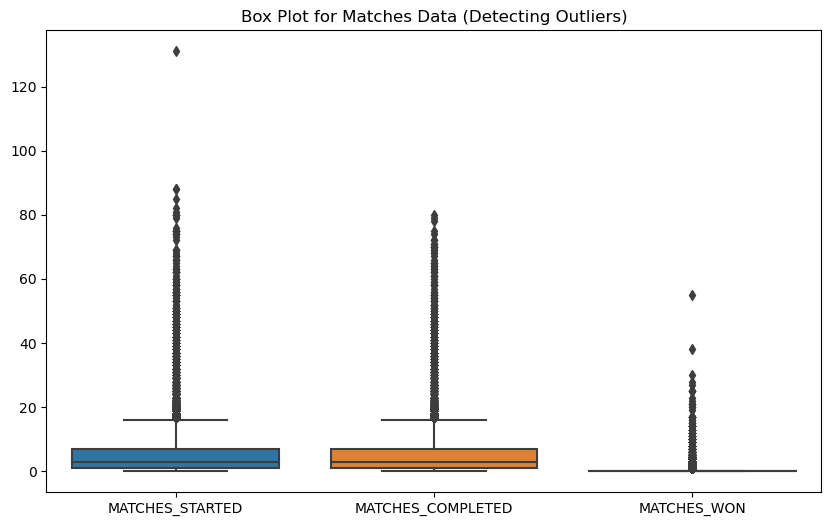

In [4]:
# Plot boxplots to visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['MATCHES_STARTED', 'MATCHES_COMPLETED', 'MATCHES_WON']])
plt.title('Box Plot for Matches Data (Detecting Outliers)')
plt.show()

#results show many outliers within the data

In [5]:
def detect_discrete_outliers(data):
    threshold = 3
    mean = data.mean()
    std = data.std()
    z_score = (data - mean)/std 
    outliers = abs(z_score) > threshold

    return outliers
#function to get rid of outliers

In [6]:
detect_discrete_outliers(data['MATCHES_STARTED'])
data = data[~detect_discrete_outliers(data['MATCHES_STARTED'])]
#using outlier function on MATCHES_STARTED

detect_discrete_outliers(data['MATCHES_COMPLETED'])
data = data[~detect_discrete_outliers(data['MATCHES_COMPLETED'])]
#using outlier function on MATCHES_COMPLETED

detect_discrete_outliers(data['MATCHES_WON'])
data = data[~detect_discrete_outliers(data['MATCHES_WON'])]
#using outlier function on MATCHES_WON


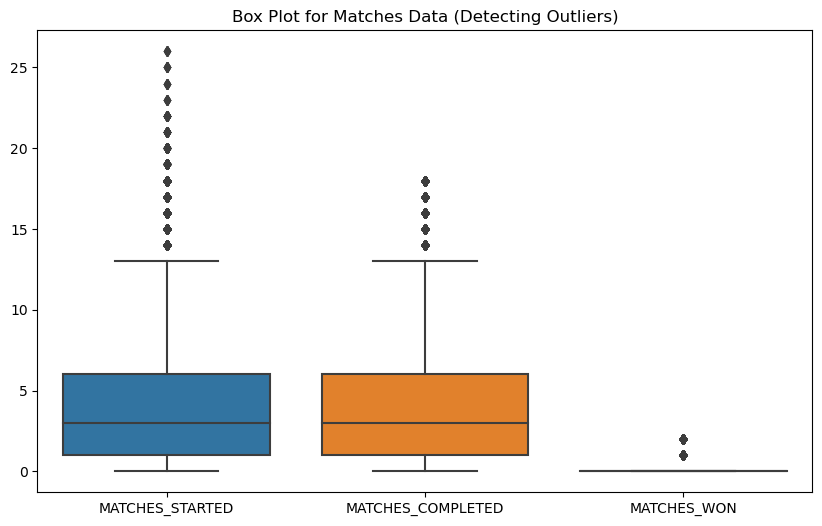

In [7]:
# Plot boxplots to visualize data after cleaning outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['MATCHES_STARTED', 'MATCHES_COMPLETED', 'MATCHES_WON']])
plt.title('Box Plot for Matches Data (Detecting Outliers)')
plt.show()

#results showcase most outliers detected were removed

In [8]:
# Print summary after outlier functions
print(f"Total Matches Started: {total_matches_started}")
print(f"Total Matches Completed: {total_matches_completed}")
print(f"Total Matches Won: {total_matches_won}")
print(f"Average Win Rate: {avg_win_rate:.2%}")
print(f"Player Retention Rate: {retention_rate:.2%}")

# Export cleaned data to CSV for visualizations in Tableau
matches_by_country.to_csv('matches_by_country.csv', index=False)


Total Matches Started: 259638
Total Matches Completed: 238878
Total Matches Won: 12506
Average Win Rate: 4.62%
Player Retention Rate: 0.33%


In [9]:
training_data = data.sample(frac=0.7, random_state=25)
testing_data = data.drop(training_data.index)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")
#spliting testing and training data with a 70/30 percentage and at a random state

No. of training examples: 30497
No. of testing examples: 13070


In [10]:
training_data.head(2)

,USER_ID,PLAY_DATE,MATCHES_STARTED,MATCHES_COMPLETED,MATCHES_WON,INSTALL_DATE,COUNTRY_CODE,WIN_RATE
21141,383ec2d3f8a554d007e853263b940c7c5445d34d,2022-06-24,2,2,0,2021-03-09,ES,0.000
11277,d1434f95bd6eff21533bfa3794176f6e661b395c,2021-05-15,8,8,1,2021-01-24,NO,0.125


In [16]:
ols_results = smf.ols('MATCHES_STARTED~ + MATCHES_COMPLETED + MATCHES_WON + WIN_RATE + retention_rate',
                      data = training_data).fit()
print(ols_results.summary())
#ols regression to determine how fit the model is (R^2) with "Matches Started" as the independent variable to determine how much the other dependent variables affect a match to start

#results showcase a high fit of the model since R^2 is close to 1 indicating that the independent and dependent variables are highly correlated

                            OLS Regression Results                            
Dep. Variable:        MATCHES_STARTED   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 1.069e+05
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:48:15   Log-Likelihood:                -38113.
No. Observations:               26705   AIC:                         7.624e+04
Df Residuals:                   26700   BIC:                         7.628e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1114      0.01

In [17]:
ols_results = smf.ols('MATCHES_STARTED~ + MATCHES_COMPLETED + MATCHES_WON + WIN_RATE + retention_rate',
                      data = testing_data).fit()
print(ols_results.summary())
#running another OLS regression on testing data for final results

#results indicate that all dependent variables besides "Matches_Won" are statistically significant for the model

                            OLS Regression Results                            
Dep. Variable:        MATCHES_STARTED   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                 5.308e+04
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:48:17   Log-Likelihood:                -15441.
No. Observations:               11477   AIC:                         3.089e+04
Df Residuals:                   11472   BIC:                         3.093e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0798      0.02

# RESULTS INTERPRETATION:
1. MATCHES_STARTED: The intercept is statistically significant at the 1% level (p < 0.01), suggesting that when all other variables are zero, the predicted value of MATCHES_STARTED is 0.0798. This could represent baseline matches started in the absence of the other factors.
2. MATCHES_COMPLETED: For each additional match completed, the number of matches started increases by approximately 1.0516, holding other variables constant. This effect is highly significant (p < 0.01), meaning MATCHES_COMPLETED is a strong predictor of MATCHES_STARTED.
3. MATCHES_WON: For each additional match won, matches started increase by 0.031, but this effect is not statistically significant (p = 0.317). The confidence interval (-0.030 to 0.092) crosses zero, suggesting that MATCHES_WON doesn't have a reliable effect on matches started.
4. WIN_RATE: A 1% increase in win rate is associated with an increase of 0.1895 in matches started. The p-value (0.061) is marginally significant (close to 0.05), indicating that WIN_RATE may have some influence on MATCHES_STARTED, but the evidence isn't very strong. The confidence interval also includes zero (-0.008 to 0.387).
5. Retention_Rate: A 1% increase in retention rate is associated with an increase of 0.0489 in matches started. This effect is statistically significant (p = 0.023), suggesting that higher retention rates are positively associated with more matches being started.

In [18]:
#Using robust regression to correct for outliers
rob_crime_model = rlm("MATCHES_STARTED~ + MATCHES_COMPLETED + MATCHES_WON + WIN_RATE + retention_rate", data=testing_data, 
M=sm.robust.norms.TukeyBiweight(3),).fit(conv="weights")
print(rob_crime_model.summary())
#rob crime linear model with testing data for final regression when accounting for outliers and heteroscedasticity

                    Robust linear Model Regression Results                    
Dep. Variable:        MATCHES_STARTED   No. Observations:                11477
Model:                            RLM   Df Residuals:                    11472
Method:                          IRLS   Df Model:                            4
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 09 Oct 2024                                         
Time:                        18:48:19                                         
No. Iterations:                    50                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -9.109e-14   8.03e-1

# RESULTS INTERPRETATION:
1. Matches_Started: The intercept is highly statistically significant (p < 0.01), but the coefficient is extremely close to zero. This suggests that when all predictor variables are zero, the number of matches started is effectively zero. The small magnitude of the coefficient (close to zero) reflects a negligible baseline value for MATCHES_STARTED when other variables are at their baseline.
2. Matches_Completed: MATCHES_COMPLETED is a perfect predictor of MATCHES_STARTED with a coefficient of exactly 1. This means that for every match completed, exactly one match is started. The statistical significance (p < 0.01) and the extremely large t-value (1.14e+15) reflect the near-perfect relationship between these two variables, suggesting they are closely tied or even collinear.
3. Matches_Won: The coefficient is very close to zero, and the p-value is high (0.848), indicating that MATCHES_WON has no significant relationship with MATCHES_STARTED. The confidence interval also crosses zero, further supporting the lack of any meaningful effect.
4. Win_Rate: WIN_RATE also has a coefficient very close to zero and is not statistically significant (p = 0.771). This indicates that changes in the win rate do not meaningfully impact MATCHES_STARTED. The confidence interval also includes zero, reinforcing the lack of effect.
5. Retention_Rate: The coefficient is negative and statistically significant (p < 0.01), indicating that higher retention_rate is associated with a decrease in MATCHES_STARTED. Although the effect size is small, the robust model suggests that even this slight negative relationship is significant. This could indicate that there is a nuanced, negative correlation between retention and matches started, although the small magnitude suggests it is a minimal impact.

# Conclusion:
The OLS model was likely influenced by outliers or data points with higher residuals, which may have skewed some of the coefficient estimates (especially for MATCHES_COMPLETED and retention_rate).

Robust Linear Model provided more pecise estimates by minimizing the effect of outliers, showing a perfect relationship  between MATCHES_COMPLETED and MATCHES_STARTED and suggesting that retention_rate has a negligible but slightly negative effect.

Further analysis and visualizations can be found in the Tableau workbook attached.